## Линейная регрессия: переобучение и регуляризация

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Знакомство с данными

In [2]:
df = pd.read_csv('d:\DownLoads\\bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

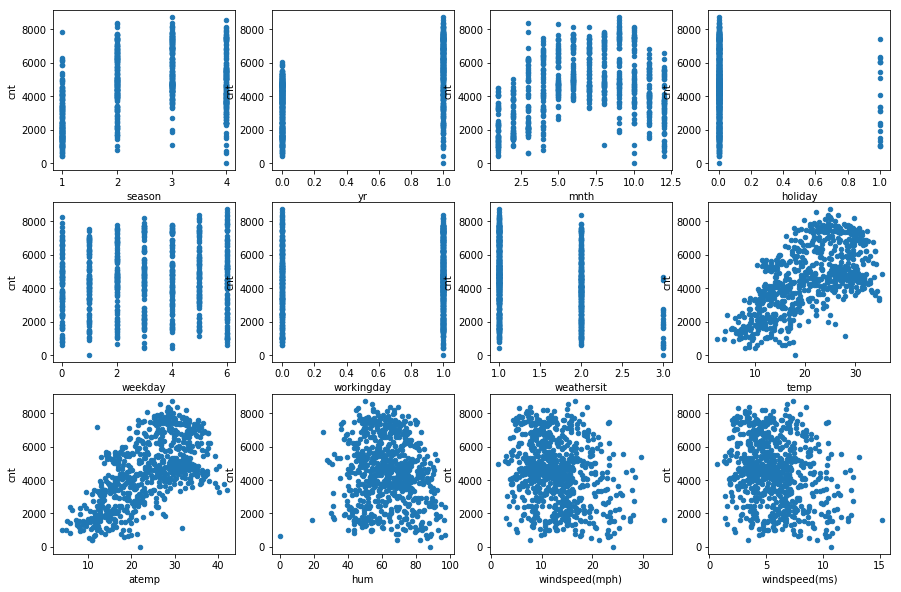

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

In [5]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
dfcorrw=df.loc[:,df.columns[:-1]].corrwith(df.loc[:,'cnt'])
dfcorrw

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

In [6]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
dfcorr=df.corr()
dfcorr

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


In [7]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

### Проблема первая: коллинеарные признаки

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [10]:
X.mean(axis=0)

array([ 2.62443965e-16, -7.77611749e-17,  3.88805875e-17,  4.86007343e-17,
        1.70102570e-17, -1.21501836e-16, -1.70102570e-17, -1.02061542e-16,
       -2.47863745e-16,  3.25624920e-16, -1.19071799e-16,  3.30484993e-16])

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lin_reg = LinearRegression()
lin_reg.fit(X,y)
list(zip(df.columns[:-1], lin_reg.coef_))

[('season', 570.8686221428004),
 ('yr', 1021.9699943158377),
 ('mnth', -141.3033812807513),
 ('holiday', -86.75513557662221),
 ('weekday', 137.22311638195657),
 ('workingday', 56.39196221110193),
 ('weathersit', -330.22958729384675),
 ('temp', 367.46593828335017),
 ('atemp', 585.5648609974869),
 ('hum', -145.60818619695488),
 ('windspeed(mph)', 12457216909218.695),
 ('windspeed(ms)', -12457216909417.148)]

In [13]:
from sklearn.linear_model import Lasso, Ridge

In [14]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
list(zip(df.columns[:-1], lasso_regressor.coef_))

[('season', 560.241616030887),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367875),
 ('holiday', -86.15278133371096),
 ('weekday', 137.34789390496329),
 ('workingday', 55.21237064135668),
 ('weathersit', -332.3698569623488),
 ('temp', 376.3632362096987),
 ('atemp', 576.5307935045507),
 ('hum', -144.12915500348595),
 ('windspeed(mph)', -197.13968940248608),
 ('windspeed(ms)', -2.8049652690829766e-08)]

In [15]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
list(zip(df.columns[:-1], ridge_regressor.coef_))

[('season', 563.0645722520173),
 ('yr', 1018.9483787875288),
 ('mnth', -131.87332028247684),
 ('holiday', -86.74609799709266),
 ('weekday', 138.00511117871898),
 ('workingday', 55.903110375064415),
 ('weathersit', -332.3497884990724),
 ('temp', 386.4578891919361),
 ('atemp', 566.3470470600394),
 ('hum', -145.07132729867294),
 ('windspeed(mph)', -99.2594410817205),
 ('windspeed(ms)', -99.25944115441294)]

### Проблема вторая: неинформативные признаки

In [16]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

def train_regressor(regressor_creator, result_matrix):
    for row_index, row in enumerate(result_matrix):
        regressor = regressor_creator(alphas[row_index])
        regressor.fit(X, y)
        for i, _ in enumerate(row):
            row[i] = regressor.coef_[i]

# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
train_regressor(lambda alpha: Lasso(alpha=alpha), coefs_lasso)
# а затем обучите Ridge и запишите веса в coefs_ridge.
train_regressor(lambda alpha: Ridge(alpha=alpha), coefs_ridge)
coefs_ridge[3]


array([ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
        110.68012006,   51.25719208, -286.12515935,  447.47982533,
        455.75402966, -151.48320603, -102.00537592, -102.00537593])

Text(0.5,1,'Ridge')

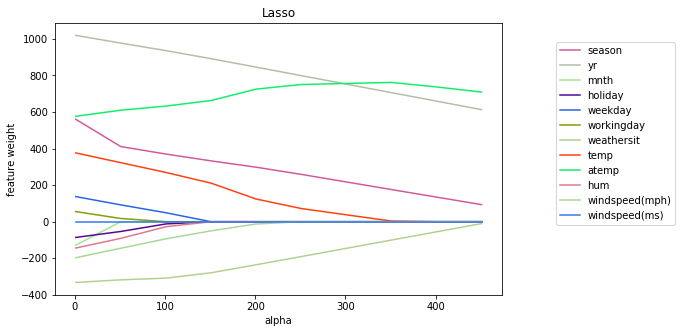

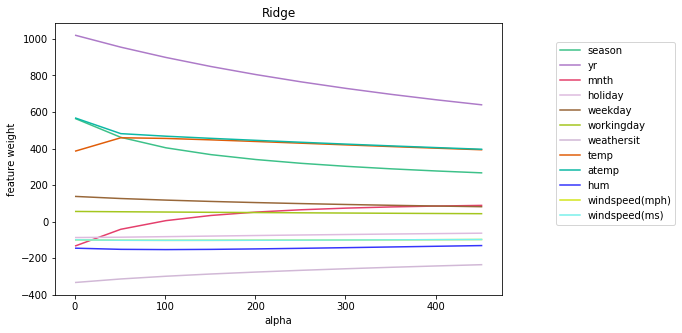

In [17]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [18]:
from sklearn.linear_model import LassoCV

best alpha_: 6


[('season', 532.0189828413537),
 ('yr', 1015.0602226430597),
 ('mnth', -100.03952614356626),
 ('holiday', -83.29395987529917),
 ('weekday', 132.50446549095795),
 ('workingday', 51.55708561407389),
 ('weathersit', -330.5598567399813),
 ('temp', 370.6798550300351),
 ('atemp', 581.3969310654967),
 ('hum', -140.0074055006887),
 ('windspeed(mph)', -191.77140847135064),
 ('windspeed(ms)', -2.6854518176296607e-08)]

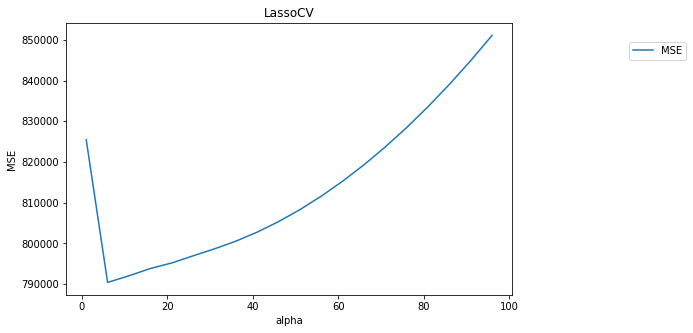

In [19]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lassocv_regressor = LassoCV(alphas=alphas)
lassocv_regressor.fit(X, y)
mse_path = lassocv_regressor.mse_path_
regressor_alphas = lassocv_regressor.alphas_
mse_results = [np.mean(row) for row in mse_path]

plt.figure(figsize=(8, 5))
plt.plot(regressor_alphas, mse_results, label="MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV")


print("best alpha_: {}".format(lassocv_regressor.alpha_))


list(zip(df.columns[:-1], lassocv_regressor.coef_))


best alpha for col1: 41
best alpha for col2: 6
best alpha for col3: 1


Text(0.5,1,'MSE for col3')

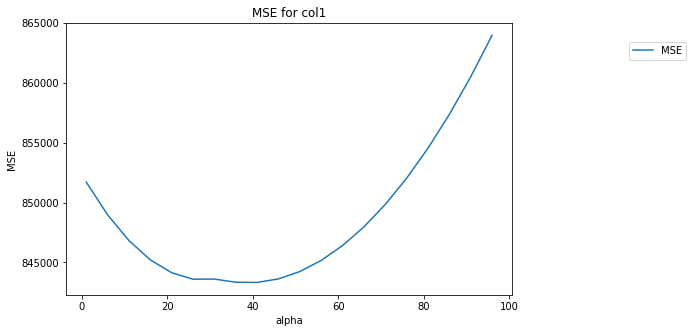

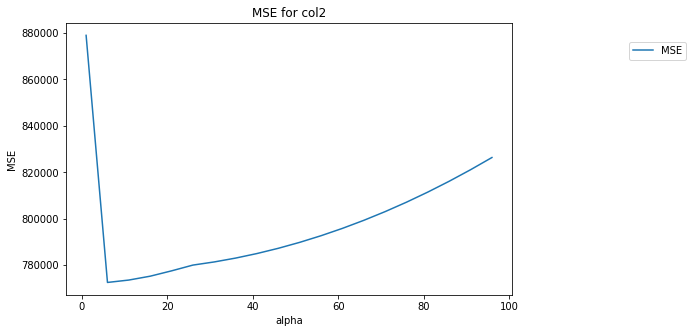

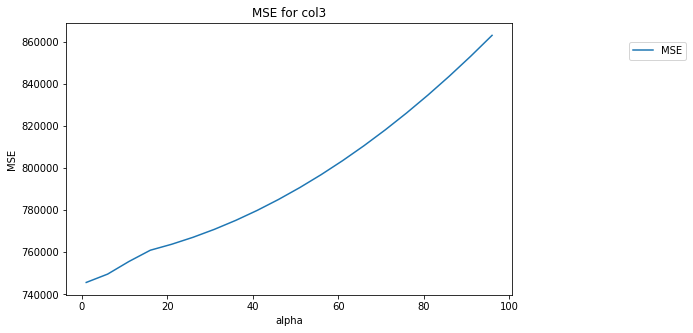

In [20]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
col1 = [mse[0] for mse in lassocv_regressor.mse_path_]
col2 = [mse[1] for mse in lassocv_regressor.mse_path_]
col3 = [mse[2] for mse in lassocv_regressor.mse_path_]
print("best alpha for col1: {}".format(lassocv_regressor.alphas_[col1.index(min(col1))]))
print("best alpha for col2: {}".format(lassocv_regressor.alphas_[col2.index(min(col2))]))
print("best alpha for col3: {}".format(lassocv_regressor.alphas_[col3.index(min(col3))]))
# На трех отдельных графиках визуализируйте столбцы .mse_path_

plt.figure(figsize=(8, 5))
plt.plot(regressor_alphas, col1, label="MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE for col1")

plt.figure(figsize=(8, 5))
plt.plot(regressor_alphas, col2, label="MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE for col2")

plt.figure(figsize=(8, 5))
plt.plot(regressor_alphas, col3, label="MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE for col3")